In [23]:
import numpy as np
import gymnasium as gym

def harvest(pop, effort):
    pop[0] = pop[0] * (1 - effort[0])
    pop[2] = pop[2] * (1 - effort[1])
    return pop

def utility(pop, effort):
    # benefit from harvesting X & Z, with fixed small fishing cost
    benefits = pop[0] * effort[0] + .01 * pop[2] * effort[1]
    costs = .01 * (effort[0] + effort[1])
    return benefits - costs

def observe(state): # perfectly observed case
    return state



In [42]:

parameters = {
         "r_x": np.float32(1.0),
         "r_y": np.float32(1.0),
         "K_x": np.float32(1.0),
         "K_y": np.float32(1.0),
         "beta": np.float32(0.3),
         "v0":  np.float32(0.1),
         "D": np.float32(1.1),
         "tau_yx": np.float32(0),
         "tau_xy": np.float32(0),
         "cV": np.float32(0.5), 
         "f": np.float32(0.25), 
         "dH": np.float32(0.45),
         "alpha": np.float32(0.3),
         "sigma_x": np.float32(0.05),
         "sigma_y": np.float32(0.05),
         "sigma_z": np.float32(0.05),
         "cost": np.float32(0.01)
        }
initial_pop = np.array([0.83, 
                        0.054,
                        0.37],
                        dtype=np.float32)
        

In [25]:
class s3a2(gym.Env):
    """A 3-species ecosystem model with two control actions"""
    def __init__(self, config=None):
        config = config or {}
                                
        ## these parameters may be specified in config                                  
        self.Tmax = config.get("Tmax", 200)
        self.threshold = config.get("threshold", np.float32(1e-4))
        self.init_sigma = config.get("init_sigma", np.float32(1e-3))
        self.training = config.get("training", True)
        self.initial_pop = config.get("initial_pop", initial_pop)
        self.parameters = config.get("parameters", parameters)
        self.observe = config.get("observe", observe)
        self.harvest = config.get("harvest", harvest)
        self.utility = config.get("utility", utility)
        self.bound = 2 * self.parameters["K_x"]
        
        self.action_space = gym.spaces.Box(
            np.array([-1, -1], dtype=np.float32),
            np.array([1, 1], dtype=np.float32),
            dtype = np.float32
        )
        self.observation_space = gym.spaces.Box(
            np.array([-1, -1, -1], dtype=np.float32),
            np.array([1, 1, 1], dtype=np.float32),
            dtype=np.float32,
        )        
        self.reset(seed=config.get("seed", None))


    def reset(self, *, seed=None, options=None):
        self.timestep = 0
        self.state = self.state_units(self.initial_pop)
        self.state += np.float32(self.init_sigma * np.random.normal(size=3) )
        info = {}
        return self.observe(self.state), info

    def step(self, action):
        action = np.clip(action, self.action_space.low, self.action_space.high)
        pop = self.population_units() # current state in natural units
        effort = (action + 1.) / 2

        # harvest and recruitment
        reward = self.utility(pop, effort)
        nextpop = self.dynamics(pop, effort)
        
        self.timestep += 1
        terminated = bool(self.timestep > self.Tmax)
        
        # in training mode only: punish for population collapse
        if any(pop <= self.threshold) and self.training:
            terminated = True
            reward -= 50/self.timestep
        
        self.state = self.state_units(nextpop) # transform into [-1, 1] space
        observation = self.observe(self.state) # same as self.state
        return observation, reward, terminated, False, {}

      
    def dynamics(self, pop, effort):

        pop = self.harvest(pop, effort)
        
        X, Y, Z = pop[0], pop[1], pop[2]
        p = self.parameters
        
        coupling = p["v0"]**2 #+ 0.02 * np.sin(2 * np.pi * self.timestep / 60)
        K_x = p["K_x"] + 0.01 * np.sin(2 * np.pi * self.timestep / 30)

        X += (p["r_x"] * X * (1 - X / K_x)
              - p["beta"] * Z * (X**2) / (coupling + X**2)
              - p["cV"] * X * Y
              + p["tau_yx"] * Y - p["tau_xy"] * X  
              + p["sigma_x"] * X * np.random.normal()
             )
        
        Y += (p["r_y"] * Y * (1 - Y / p["K_y"] )
              - p["D"] * p["beta"] * Z * (Y**2) / (coupling + Y**2)
              - p["cV"] * X * Y
              - p["tau_yx"] * Y + p["tau_xy"] * X  
              + p["sigma_y"] * Y * np.random.normal()
             )

        Z = Z + p["alpha"] * (
                              Z * (p["f"] * ( 
                                             X**2 / (coupling + X**2) 
                                             + p["D"] * Y**2 / (coupling + Y**2)
                                             ) - p["dH"]) 
                              + p["sigma_z"] * Z  * np.random.normal()
                             )        
        
        # consider adding the handling-time component here too instead of these   
        #Z = Z + p["alpha"] * (Z * (p["f"] * (X + p["D"] * Y) - p["dH"]) 
        #                      + p["sigma_z"] * Z  * np.random.normal())
                              
        pop = np.array([X, Y, Z], dtype=np.float32)
        return(pop)

    
    # inverse of self.population()
    def state_units(self, pop):
        pop = np.clip(pop, 0, np.Inf) # enforce non-negative population first
        self.state = np.array([
          2 * pop[0] / self.bound - 1,
          2 * pop[1] / self.bound - 1,
          2 * pop[2] / self.bound - 1],
          dtype=np.float32)
        return self.state
    
    def population_units(self):
        pop = np.array(
          [(self.state[0] + 1) * self.bound / 2,
           (self.state[1] + 1) * self.bound / 2,
           (self.state[2] + 1) * self.bound / 2],
           dtype=np.float32)
        return np.clip(pop, 0, np.Inf)
    
    
    


In [53]:

def utility(pop, effort):
    # benefit from harvesting X & Z, with fixed small fishing cost
    benefits = pop[0] * effort[0] + .01 * pop[2] * effort[1]
    costs = .01 * (effort[0] + effort[1])
    return benefits - costs
env = s3a2(config = {"utility": utility})


from stable_baselines3.common.env_checker import check_env
check_env(env)
action = np.array([-1,-1], dtype=np.float32)


In [54]:

action = np.array([-1,-1])
env.step(action)

(array([-0.5860036 , -0.7056198 , -0.94643146], dtype=float32),
 0.0,
 False,
 False,
 {})

In [58]:

df = []
episode_reward = 0
observation, _ = env.reset()
for t in range(env.Tmax):
  obs = (observation + 1 ) / 2 # natural units
  df.append(np.append([t, episode_reward], obs))
  observation, reward, terminated, done, info = env.step(action)
  episode_reward += reward
  if terminated or done:
    break

episode_reward


0.0

In [60]:
df

[array([0.        , 0.        , 0.41569862, 0.02629989, 0.18516055]),
 array([1.        , 0.        , 0.40358472, 0.02781549, 0.17957175]),
 array([2.        , 0.        , 0.41132441, 0.02521345, 0.17463306]),
 array([3.        , 0.        , 0.43878734, 0.02628243, 0.16608614]),
 array([4.        , 0.        , 0.45022228, 0.03053164, 0.15757689]),
 array([5.        , 0.        , 0.42947444, 0.03169197, 0.1503042 ]),
 array([6.        , 0.        , 0.43504176, 0.03255418, 0.14500225]),
 array([7.        , 0.        , 0.42257947, 0.03415936, 0.13915664]),
 array([8.        , 0.        , 0.45135432, 0.03525543, 0.13277793]),
 array([9.        , 0.        , 0.40899152, 0.0368211 , 0.12778091]),
 array([10.        ,  0.        ,  0.40752396,  0.04081592,  0.12442374]),
 array([11.        ,  0.        ,  0.41992941,  0.04451215,  0.12124705]),
 array([12.        ,  0.        ,  0.44044426,  0.04899523,  0.11912057]),
 array([13.        ,  0.        ,  0.45642453,  0.05126479,  0.11551404]),


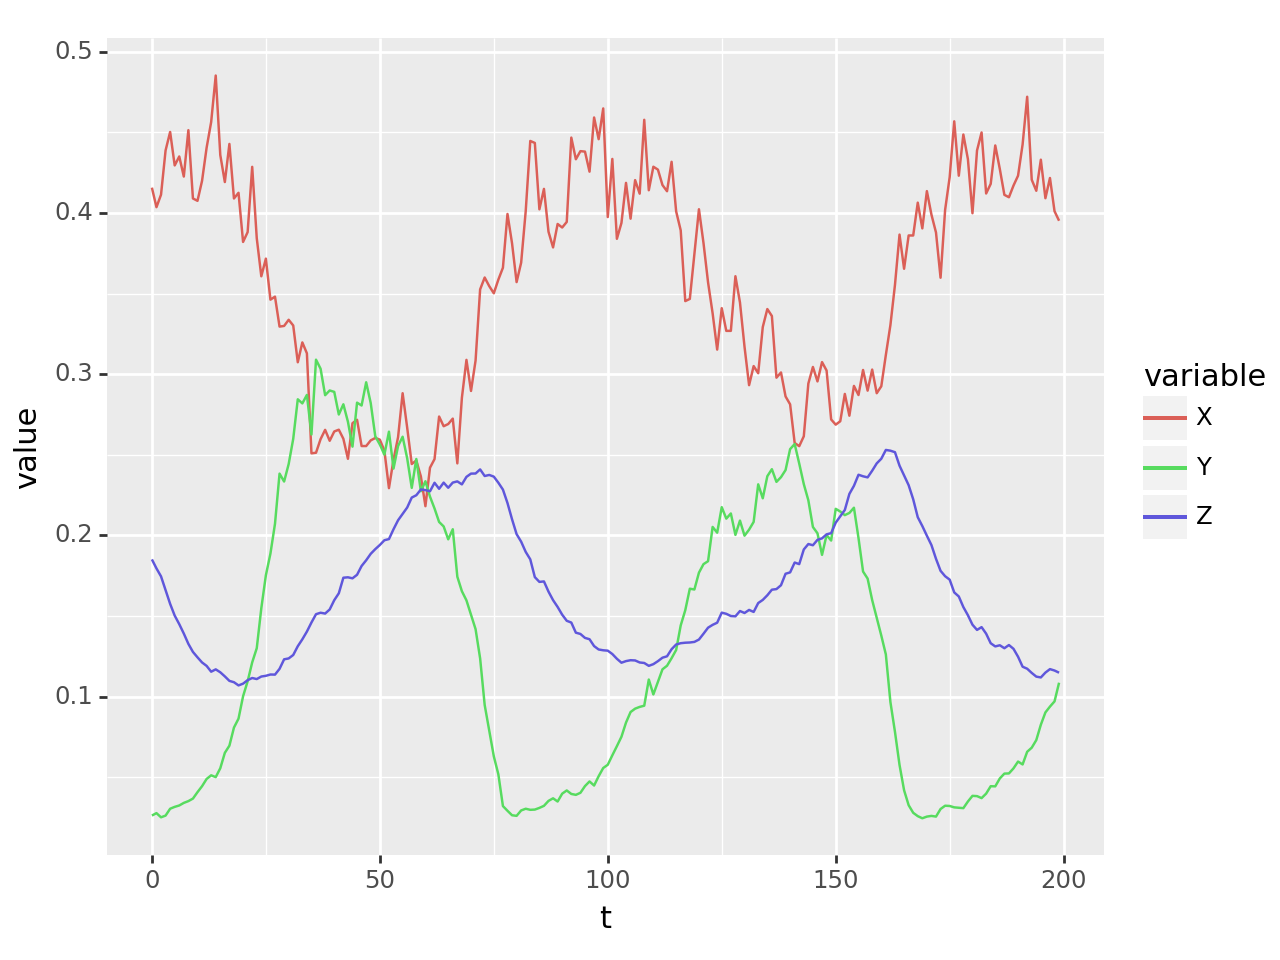

<Figure Size: (640 x 480)>

In [62]:
import polars as pl
from plotnine import ggplot, aes, geom_line
cols = ["t", "reward", "X", "Y", "Z"]

dfl = (pl.DataFrame(df, schema=cols).
        select(["t", "X", "Y", "Z"]).
        melt("t")
      )
ggplot(dfl, aes("t", "value", color="variable")) + geom_line()

